# ▒ 고급회귀분석 ▒

## 0. 환경설정

In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf

## 1. 데이터 준비

### 데이터 설명 (fat dataset)

- 252명의 남성의 나이, 몸무게, 키 등의 신체 정보와 비만도를 측정한 자료.
- 나머지 정보를 이용해서 비만도 (brozek)를 예측하는 모형을 구축하자.

### 데이터 호출

In [50]:
data_file = "./data/fat.csv"
fat = pd.read_csv(data_file)
print(fat.shape)
fat.head()

(252, 18)


,brozek,siri,density,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
0,12.6,12.3,1.0708,23,154.25,67.75,23.7,134.9,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.9,6.1,1.0853,22,173.25,72.25,23.4,161.3,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,24.6,25.3,1.0414,22,154.00,66.25,24.7,116.0,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.9,10.4,1.0751,26,184.75,72.25,24.9,164.7,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,27.8,28.7,1.0340,24,184.25,71.25,25.6,133.1,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [19]:
xfat = fat.drop(['brozek'], axis=1)
yfat = fat['brozek']

## 1. 주성분분석 (PCA)
### 주성분분석을 위해서는 설명 변수 데이터를 표준화하는 작업이 선행되어야 함.

In [20]:
xfat_st = preprocessing.StandardScaler().fit_transform(xfat)
feature_names = ['siri', 'density', 'age', 'weight', 'height', 'adipos', 'free', 'neck',
       'chest', 'abdom', 'hip', 'thigh', 'knee', 'ankle', 'biceps', 'forearm',
       'wrist']
xfat_st = pd.DataFrame(xfat_st, columns=feature_names)
xfat_st.head()

,siri,density,age,weight,height,adipos,free,neck,chest,abdom,hip,thigh,knee,ankle,biceps,forearm,wrist
0,-0.820246,0.801647,-1.740073,-0.841246,-0.656205,-0.477058,-0.484401,-0.738665,-0.918048,-0.683533,-0.755929,-0.077479,-0.536131,-0.710826,-0.090676,-0.626718,-1.212541
1,-1.562573,1.565061,-1.819583,-0.193462,0.574790,-0.559456,0.966512,0.209365,-0.858621,-0.887963,-0.168502,-0.134736,-0.536131,0.175947,-0.588143,0.117079,-0.031943
2,0.736245,-0.746240,-1.819583,-0.849769,-1.066536,-0.202398,-1.523123,-1.645475,-0.597144,-0.432643,-0.098570,0.037035,0.128592,0.530656,-1.151940,-1.717621,-1.749177
3,-1.047733,1.028039,-1.501543,0.198617,0.574790,-0.147466,1.153373,-0.244041,0.115976,-0.572026,0.181157,0.132464,-0.536131,-0.178762,0.041982,0.365012,-0.031943
4,1.143327,-1.135844,-1.660563,0.181570,0.301235,0.044796,-0.583327,-1.480601,-0.418864,0.691719,0.279061,0.724121,1.499585,0.530656,-0.024347,-0.477959,-0.568578


### 주성분분석 실행하기

In [65]:
pca = PCA(n_components = 10)
pca_components = pca.fit_transform(xfat_st)
pca_xfat = pd.DataFrame(data=pca_components,columns=
                        ['pc1','pc2','pc3','pc4','pc5',
                         'pc6','pc7','pc8','pc9','pc10'])
pca_xfat.head()

(252, 10)


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10
0,-2.555110,-0.642961,1.847360,0.353975,-0.215243,-0.259544,-0.056970,0.350679,0.145460,-0.073107
1,-1.434682,-2.932980,0.672117,0.377292,-0.034448,-0.200036,-0.586670,-0.473018,0.352508,-0.193671
2,-2.157678,1.387028,2.872635,-1.240407,1.526779,0.591437,0.039899,-0.113380,0.233466,0.045837
3,-0.353587,-2.243396,0.780617,0.294658,-0.431292,-0.502801,-0.432545,-0.293055,-0.251761,0.537481
4,0.638617,0.489410,2.185015,-1.913758,0.691903,0.625321,1.099185,-0.016946,0.357656,0.509276


### 최적의 주성분 수 계산하기
- Scree plot을 이용하여 최적의 주성분 수를 구함.
- Scree plot: PCA 분석 후 주성분 수를 선정하기 위해 고유값-주성분의 분산 변화를 보는 그래프
- 분산 변화율이 완만해지는 주성분의 수를 선정
- 해당 데이터의 경우 주성분 3개가 적당해보임

Text(0, 0.5, 'Propotion of Variance')

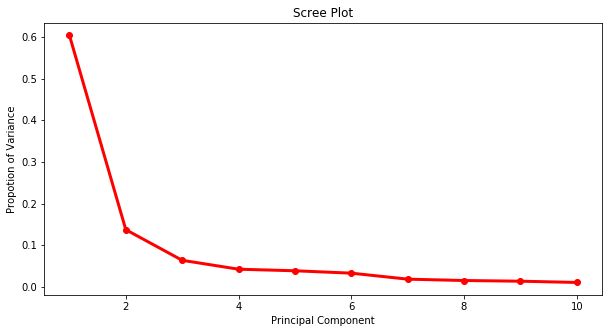

In [66]:
fig = plt.figure(figsize = (10, 5))
sing_vals = np.arange(10) + 1
plt.plot(sing_vals, pca.explained_variance_ratio_, 
         'ro-', linewidth = 3)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Propotion of Variance')

## 3. 주성분 회귀분석
### 3개의 주성분으로 비만도를 예측하는 선형모형을 적합하자.

In [64]:
pca_fat = pd.concat([yfat,pca_xfat[['pc1', 'pc2', 'pc3']]], axis=1)
## 선형모형 적합
pcalmfit = smf.ols(formula='brozek~pc1+pc2+pc3', data=pca_fat).fit()
print(pcalmfit.summary())

                            OLS Regression Results                            
Dep. Variable:                 brozek   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     757.4
Date:                Mon, 06 Jun 2022   Prob (F-statistic):          1.62e-124
Time:                        14:09:14   Log-Likelihood:                -580.96
No. Observations:                 252   AIC:                             1170.
Df Residuals:                     248   BIC:                             1184.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.9385      0.154    122.910      0.0

## 4. Shrinkage Method
### 4-1. Ridge regression

In [137]:
alphas = np.logspace(2, -10, 200)
rmse = []
for alpha in alphas:
    neg_mse_scores = cross_val_score(Ridge(alpha), xfat_st, yfat, 
                                     scoring='neg_mean_squared_error', cv=3)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    rmse.append(np.mean(rmse_scores))

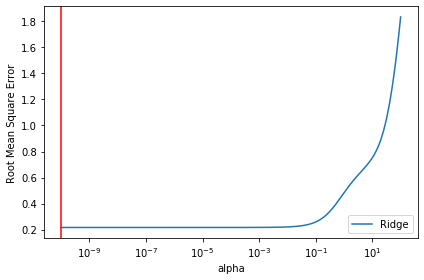

In [138]:
best_alpha = alphas[list(rmse==min(rmse)).index(True)]
plt.plot(alphas, rmse, label=Ridge.__name__)
plt.axvline(best_alpha, color = 'r')
plt.legend(loc = 'lower right')
plt.xscale("log")
plt.xlabel('alpha')
plt.ylabel('Root Mean Square Error')
plt.tight_layout()
plt.show()

In [141]:
optimal_ridge = Ridge(best_alpha)
optimal_ridge.fit(xfat_st, yfat)
print(optimal_ridge.intercept_)
print(optimal_ridge.coef_)

18.938492063492067
[ 7.42009341e+00 -1.87004321e-01 -6.62524123e-03  2.48887207e-01
 -1.99545282e-03 -5.57956160e-02 -1.77200971e-01  1.21347867e-03
  1.80509937e-02  1.55655884e-02 -3.18267718e-02  8.22217091e-02
 -6.06869824e-02  4.70068114e-03 -4.43648926e-02  3.02468282e-02
  3.04227118e-02]


### 4-2. Lasso regression

In [146]:
alphas = np.logspace(1, -5, 200)
rmse = []
for alpha in alphas:
    neg_mse_scores = cross_val_score(Lasso(alpha, max_iter=10000), xfat_st, yfat, 
                                     scoring='neg_mean_squared_error', cv=3)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    rmse.append(np.mean(rmse_scores))

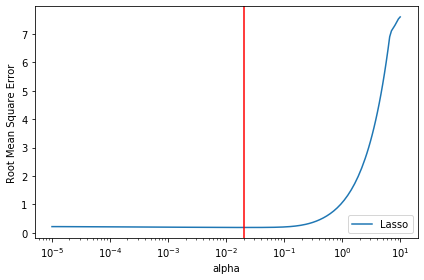

In [147]:
best_alpha = alphas[list(rmse==min(rmse)).index(True)]
plt.plot(alphas, rmse, label=Lasso.__name__)
plt.axvline(best_alpha, color = 'r')
plt.legend(loc = 'lower right')
plt.xscale("log")
plt.xlabel('alpha')
plt.ylabel('Root Mean Square Error')
plt.tight_layout()
plt.show()

In [149]:
optimal_lasso = Lasso(best_alpha)
optimal_lasso.fit(xfat_st, yfat)
print(optimal_lasso.intercept_)
print(optimal_lasso.coef_)

18.938492063492067
[ 7.57372300e+00 -1.37753930e-01 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.41373707e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.68691580e-04
  0.00000000e+00]
